In [1]:
using Images
using Statistics
using Plots
using DSP
using StatsBase
using VectorizedStatistics
using ImageMorphology

In [116]:
file = "../fig4-patchDynamics/movies-Pak1-GFP/2024_07_08-PolProbeMovies/1patch/movie2-cell9.tif"
file = "../fig6-deletions/2024_09_26-3XGBwt/1patch/movie1_cell6.tif"
img = load(file)
im_array = Float64.(img) * 65535 # concert to 16bit
t = range(0,60/5*30)*(5/60); # Convert from 1 frame every 5 sec, to minutes
t = range(0,60/15*30)*(15/60); # Convert from 1 frame every 15 sec, to minutes

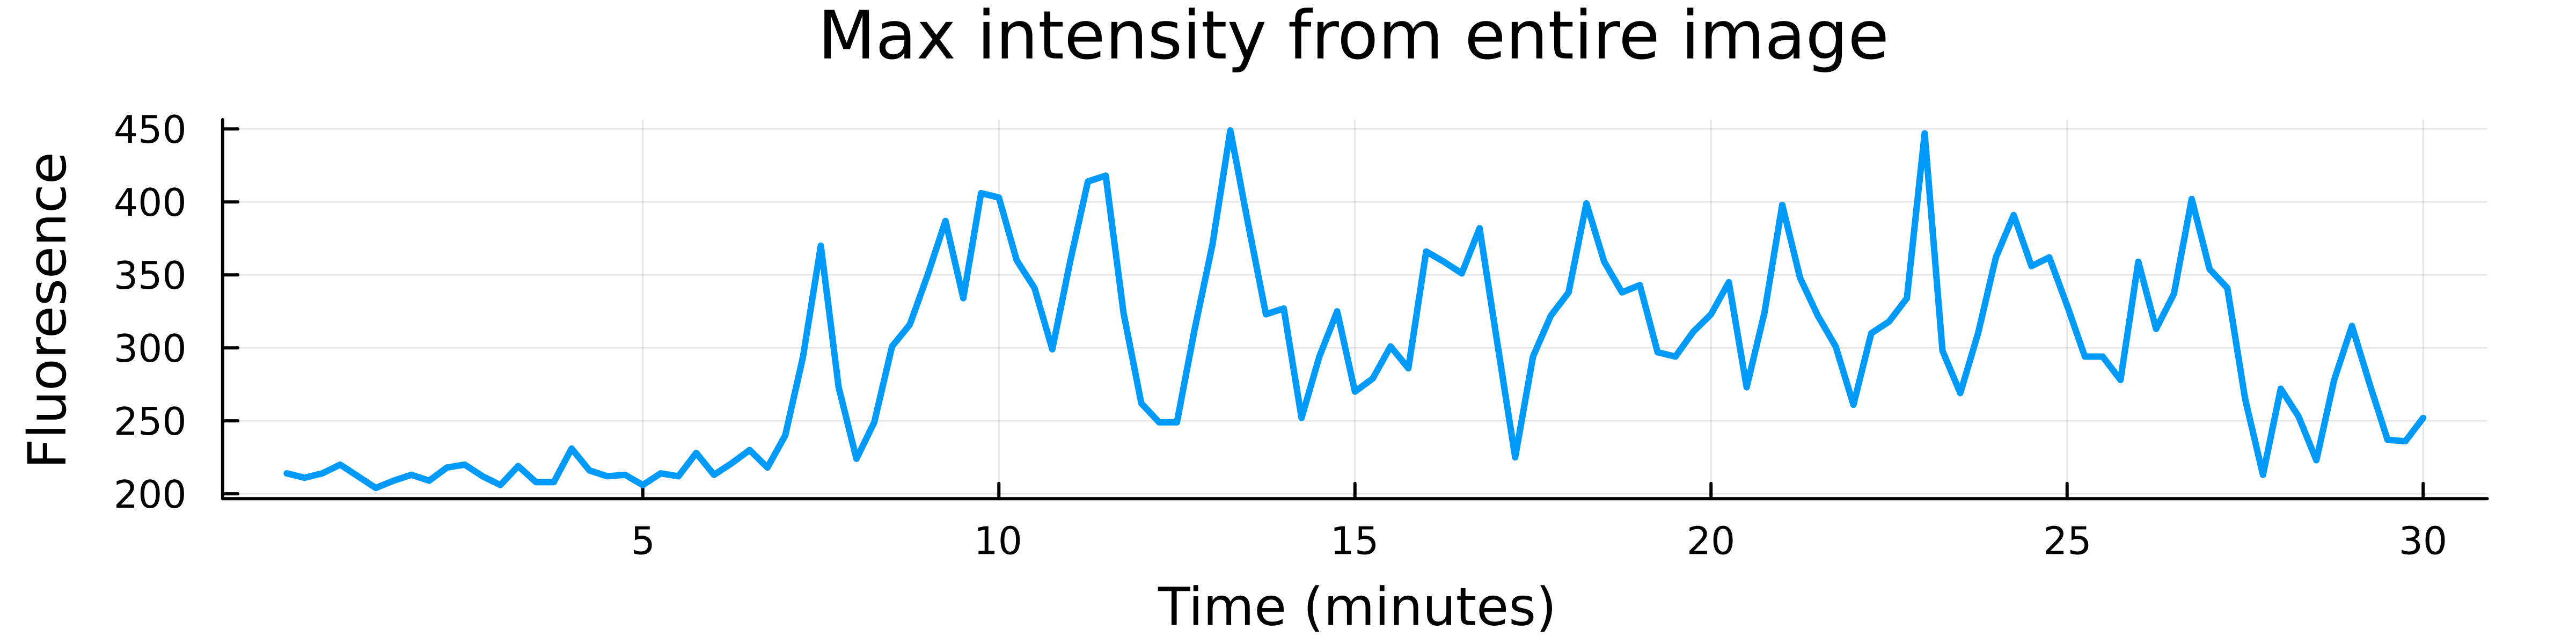

In [119]:
signal_max = maximum(im_array, dims=(1,2))[1,1,:]
plot(t, signal_max, xticks=range(1,6)*5, linewidth=2, label=false, dpi=600,
    xlabel="Time (minutes)", ylabel="Fluoresence", size=(800,200), margin=5Plots.mm, title="Max intensity from entire image")
#savefig("max_trace.png")
#savefig("max_trace_3XGB.png")

In [121]:
img_std = std(im_array, dims=(3))[:,:,1]
img_mean = mean(im_array, dims=(3))[:,:,1];

In [126]:
heatmap(img_mean, yflip=true, dpi=600)
#savefig("mean-image.png")
#savefig("mean-image-3XGB.png")
maximum(img_mean), img_mean[40,40], img_mean[5,5]

BoundsError: BoundsError: attempt to access 31×43 Matrix{Float64} at index [40, 40]

In [127]:
heatmap(img_std, yflip=true, dpi=600)
#savefig("standard-deviation-image.png")
#savefig("standard-deviation-image-3XGB.png")
maximum(img_std), img_std[40,40], img_std[5,5]

BoundsError: BoundsError: attempt to access 31×43 Matrix{Float64} at index [40, 40]

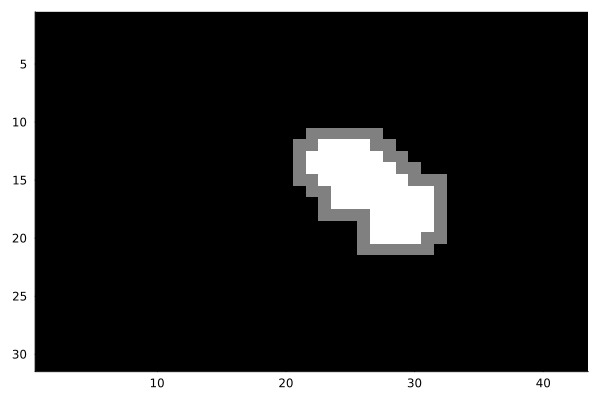

In [123]:
bin = img_std .> maximum(img_std)*0.3
heatmap(bin.+dilate(bin), cmap=["black","grey","white"], cbar=false, yflip=true)
#savefig("binary_dilation.png")

┌ Info: Saved animation to /home/dinosaur/Lab/Polarity/proj/signal_and_noise/masked_oscillations_3XGB.gif
└ @ Plots /home/dinosaur/.julia/packages/Plots/HyyIK/src/animation.jl:156


Plots.AnimatedGif("/home/dinosaur/Lab/Polarity/proj/signal_and_noise/masked_oscillations_3XGB.gif")
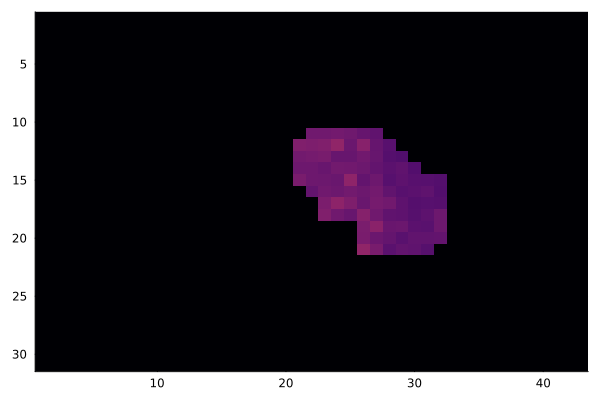

In [134]:
bin = img_std .> maximum(img_std)*0.3
anim = @animate for i in 1:length(im_array[1,1,:])
    heatmap(im_array[:,:,i].*dilate(bin,r=1), cbar=false, yflip=true, clim=(0, maximum(im_array)))
end
#gif(anim, fps=15)
gif(anim, "masked_oscillations_3XGB.gif", fps=15)

In [128]:
bin_lab = label_components(bin)             # find all connected components and label them
max_loc = findmax(bin.*img_std)[2]          # select location of brightest component
max_lab = bin_lab[max_loc]                  # get label in labeled mask from coords
max_bin = bin_lab .== max_lab               # Make binary mask only around correct component
im_masked = im_array .* max_bin;

In [129]:
im_size = length(im_masked[:,1,1,1])*length(im_masked[1,:,1,1])
signal_q3 = vquantile(im_masked, (im_size-3)/im_size, dims=(1,2))[1,1,:]
signal_q5 = vquantile(im_masked, (im_size-5)/im_size, dims=(1,2))[1,1,:]
signal_q10 = vquantile(im_masked, (im_size-10)/im_size, dims=(1,2))[1,1,:];

In [131]:
plot(t, signal_max, xticks=range(1,6)*5, linewidth=2, label="brightest pixel", dpi=600,
    xlabel="Time (minutes)", ylabel="Fluoresence", size=(800,400), margin=5Plots.mm, title="Max intensity vs Nth brightest pixel")
plot!(t, signal_q3, xticks=range(1,6)*5, linewidth=2, label="3rd brightest pixel", dpi=600,
    xlabel="Time (minutes)", ylabel="Fluoresence", size=(800,400), margin=5Plots.mm)
plot!(t, signal_q5, xticks=range(1,6)*5, linewidth=2, label="5th brightest pixel", dpi=600,
    xlabel="Time (minutes)", ylabel="Fluoresence", size=(800,400), margin=5Plots.mm)
plot!(t, signal_q10, xticks=range(1,6)*5, linewidth=2, label="10th brightest pixel", dpi=600,
    xlabel="Time (minutes)", ylabel="Fluoresence", size=(800,400), margin=5Plots.mm)
#savefig("max_traces_q10.png")
#savefig("max_traces_q10_3XGB.png")

"/home/dinosaur/Lab/Polarity/proj/signal_and_noise/max_traces_q10_3XGB.png"

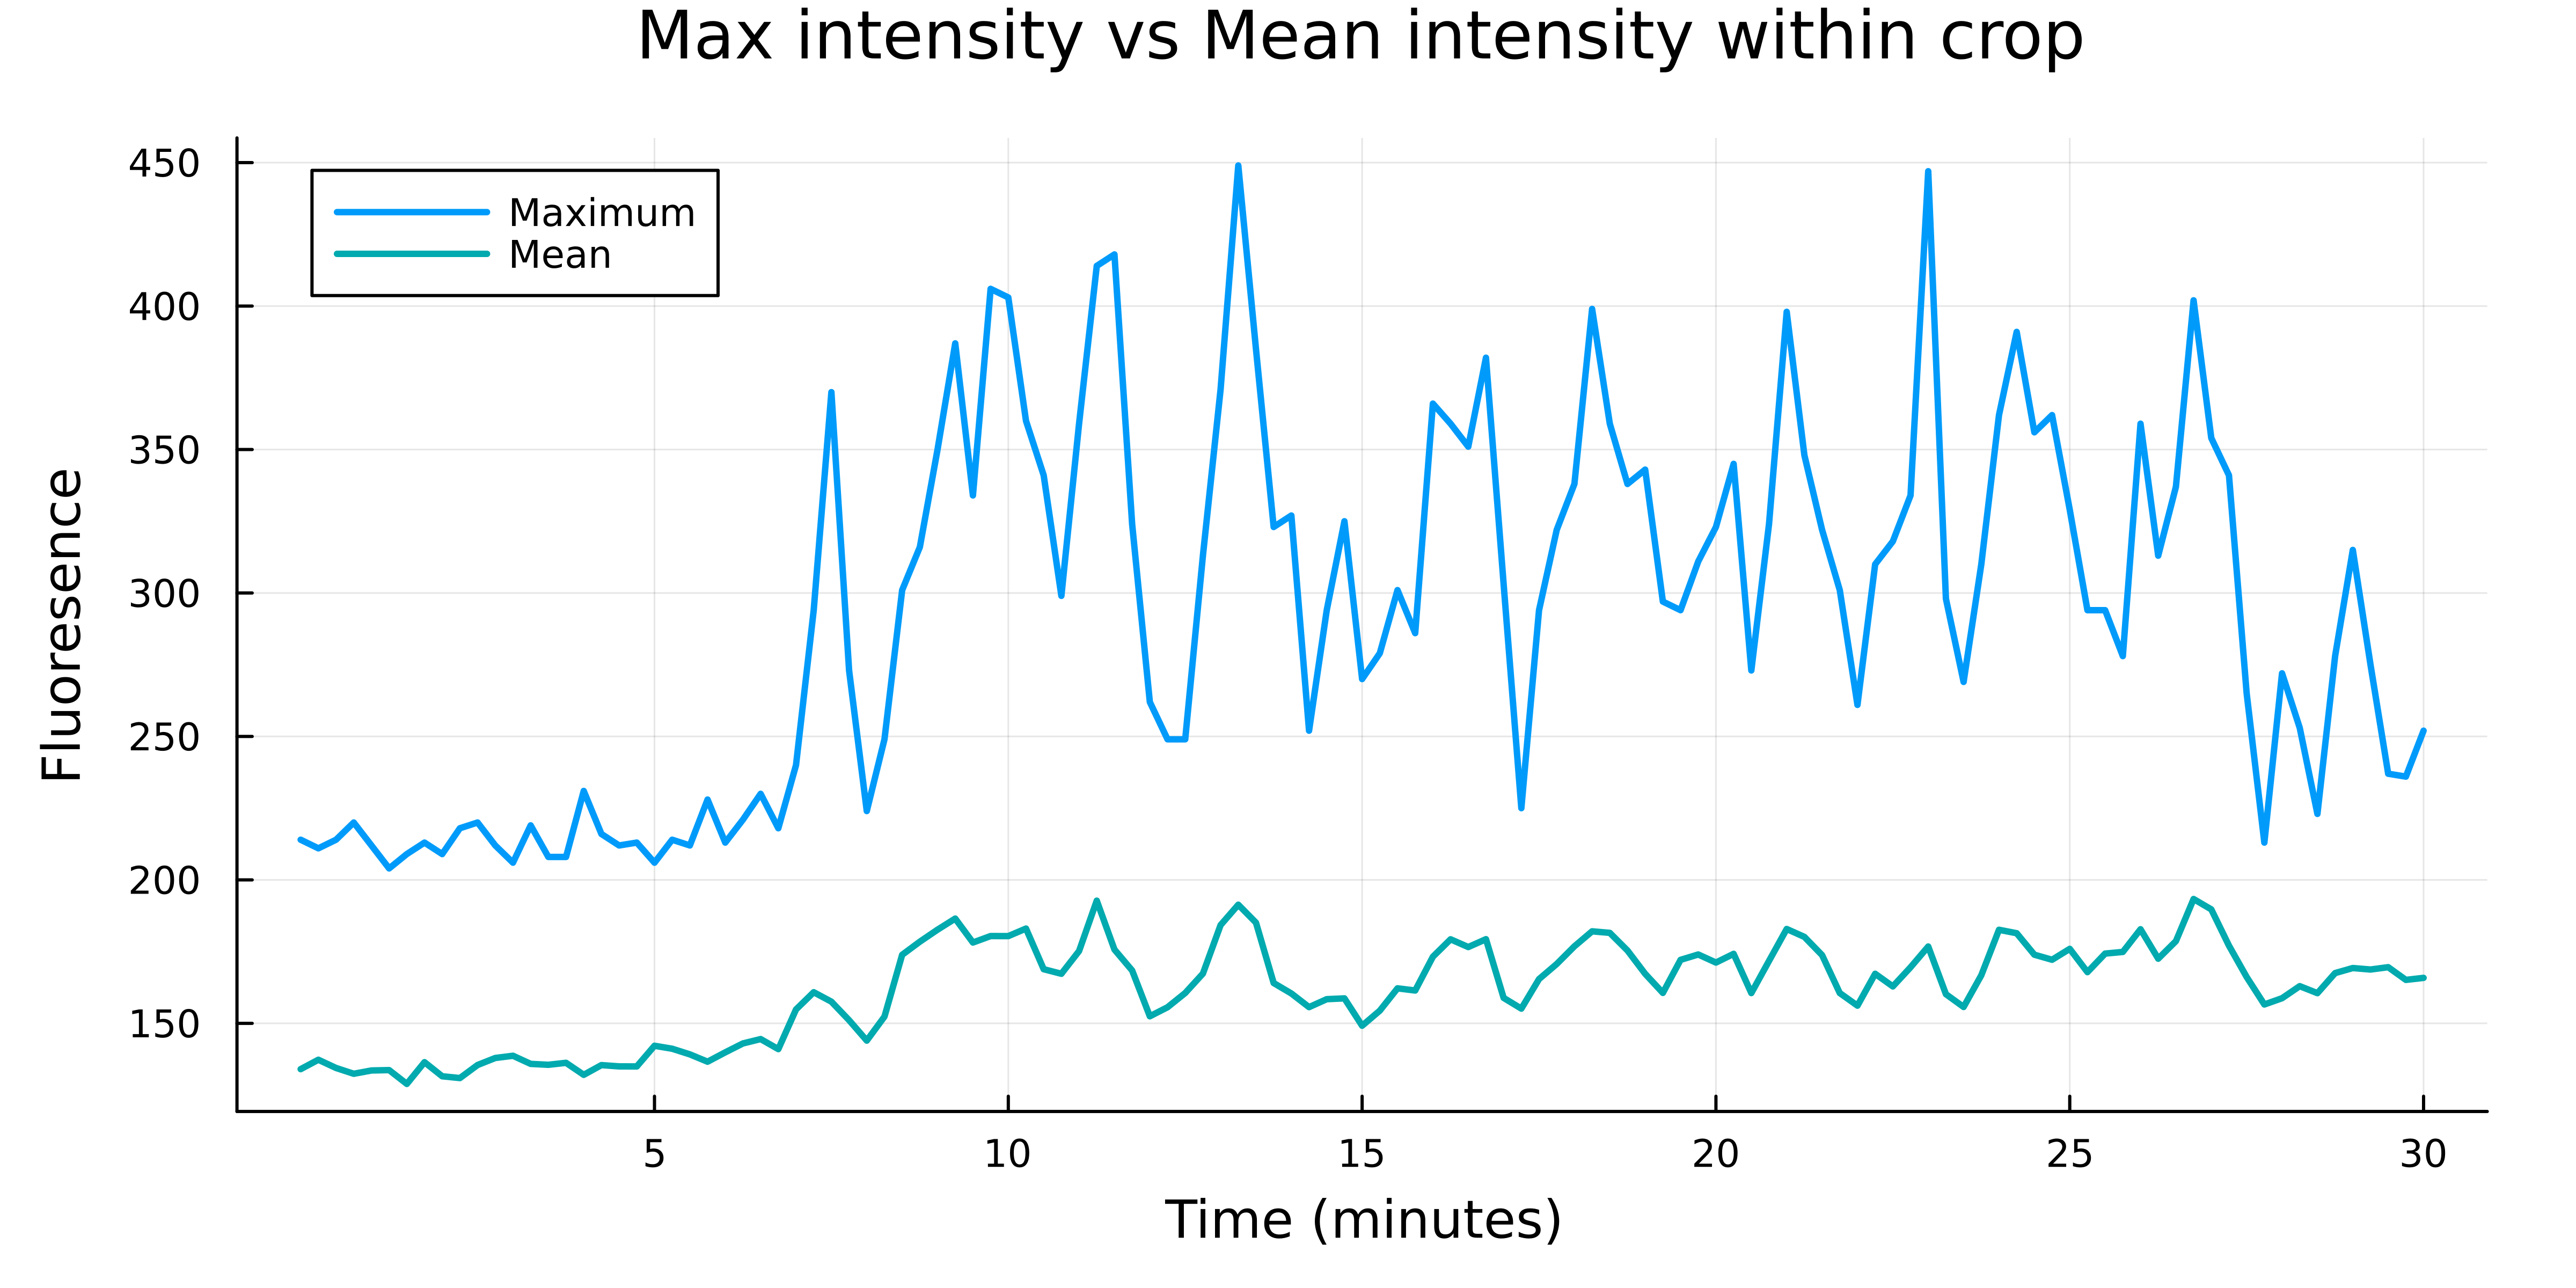

In [132]:
signal_mean = sum(im_masked, dims=(1,2))[1,1,:] ./ sum(im_masked .> 0, dims=(1,2))[1,1,:]
plot(t, signal_max, xticks=range(1,6)*5, linewidth=2, label="Maximum", dpi=600,
    xlabel="Time (minutes)", ylabel="Fluoresence", size=(800,400), margin=5Plots.mm)
plot!(t, signal_mean, xticks=range(1,6)*5, linewidth=2, label="Mean", dpi=600, color=6,
    xlabel="Time (minutes)", ylabel="Fluoresence", size=(800,400), margin=5Plots.mm, title="Max intensity vs Mean intensity within crop")
#savefig("max_mean_traces.png")
#savefig("max_mean_traces_3XGB.png")

In [182]:
function crop_time(signal, frames, thresh)
    min = minimum(signal)
    signal = signal .- min
    start = Integer(findall(signal .> (maximum(signal))*thresh)[1])
    if start + frames < length(signal)
        crop_signal = signal[start:start+Integer(frames)]
        return crop_signal .+ min
    else 
        print(".")
        crop_signal = signal[end-Integer(frames):end]
        return crop_signal .+ min
    end
end

crop_time (generic function with 1 method)

In [195]:
crop_max = crop_time(signal_max, 60, 0.5)
plot(range(0,60)./15, crop_max, xticks=range(0,15), linewidth=2, label=false, dpi=600,
    xlabel="Time (minutes)", ylabel="Fluoresence", size=(800,200), margin=5Plots.mm, title="Max intensity from entire image")
#savefig("crop_max_3XGB.png")

"/home/dinosaur/Lab/Polarity/proj/signal_and_noise/crop_max_3XGB.png"

In [197]:
pdg_crop_max = DSP.Periodograms.periodogram(crop_max)
plot(1 ./ pdg_crop_max.freq[3:end] .* (15/60), pdg_crop_max.power[3:end], xflip = false, label=false, linewidth=2, alpha=1, margin=5Plots.mm, color=5,
    size=(400, 200), dpi=600, xlabel="Period (minutes)", ylabel="Power / frequency")
#savefig("pdg_3xGB.png")

"/home/dinosaur/Lab/Polarity/proj/signal_and_noise/pdg_3xGB.png"

In [198]:
ac = crosscor(crop_max, crop_max, 0:30)
plot(range(0,30).*(15/60), ac, x_ticks=0:8, alpha=1, linewidth=2, color = 3, label=false, margin=5Plots.mm,
    size=(400, 200), dpi=600, xlabel="Lag (minutes)", ylabel="Autocorrelation")
#savefig("ac_3xGB.png")

"/home/dinosaur/Lab/Polarity/proj/signal_and_noise/ac_3xGB.png"

In [162]:
dS = zeros(length(crop_max)-1)
for i in range(1,length(crop_max)-1)
    d = crop_max[i+1] - crop_max[i]
    dS[i] = d
end
plot(dS)
print(mean(abs.(dS)))

40.36666666666667

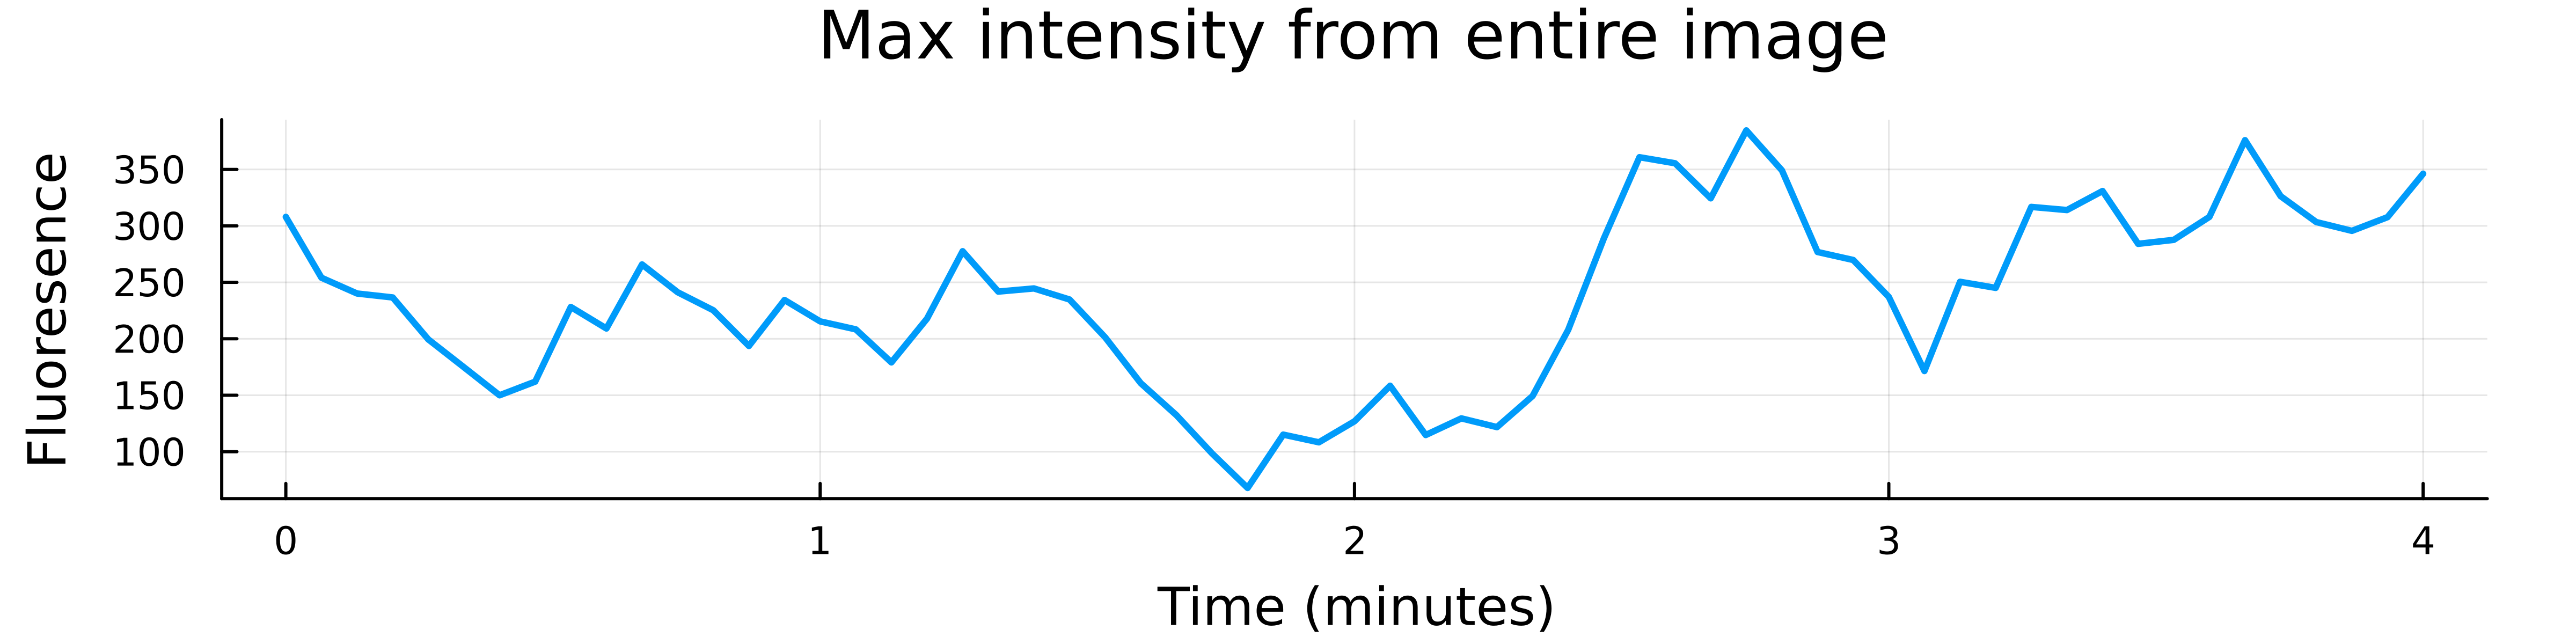

In [252]:
function gen_rand_trace(mean)
    x = mean
    X = zeros(61)
    for i in range(1,61)
        x += 2*(rand() - .5) * 80
        x += 0.1*(300 - x)
        X[i] = x
    end
    return X
end
X = gen_rand_trace(300)
plot(range(0,60)./15, X, xticks=range(0,15), linewidth=2, label=false, dpi=600,
    xlabel="Time (minutes)", ylabel="Fluoresence", size=(800,200), margin=5Plots.mm, title="Max intensity from entire image")
#savefig("biased_drift.png")

In [253]:
avg_ac = zeros(10000, 31)
avg_pdg = zeros(10000, 32)
avg_pdg
for n in range(1,10000)
    X = gen_rand_trace(300)
    ac = crosscor(X, X, 0:30)
    pdg = DSP.Periodograms.periodogram(X)
    avg_ac[n, :] = ac
    avg_pdg[n, :] = pdg.power
end

In [257]:
plot(range(0,30).*(15/60), mean(avg_ac, dims=(1))[:], x_ticks=0:8, alpha=1, linewidth=2, color = 3, label=false, margin=5Plots.mm,
    size=(400, 200), dpi=600, xlabel="Lag (minutes)", ylabel="Autocorrelation")
savefig("biased_drift_avg_ac_0p1.png")


"/home/dinosaur/Lab/Polarity/proj/signal_and_noise/biased_drift_avg_ac_0p1.png"

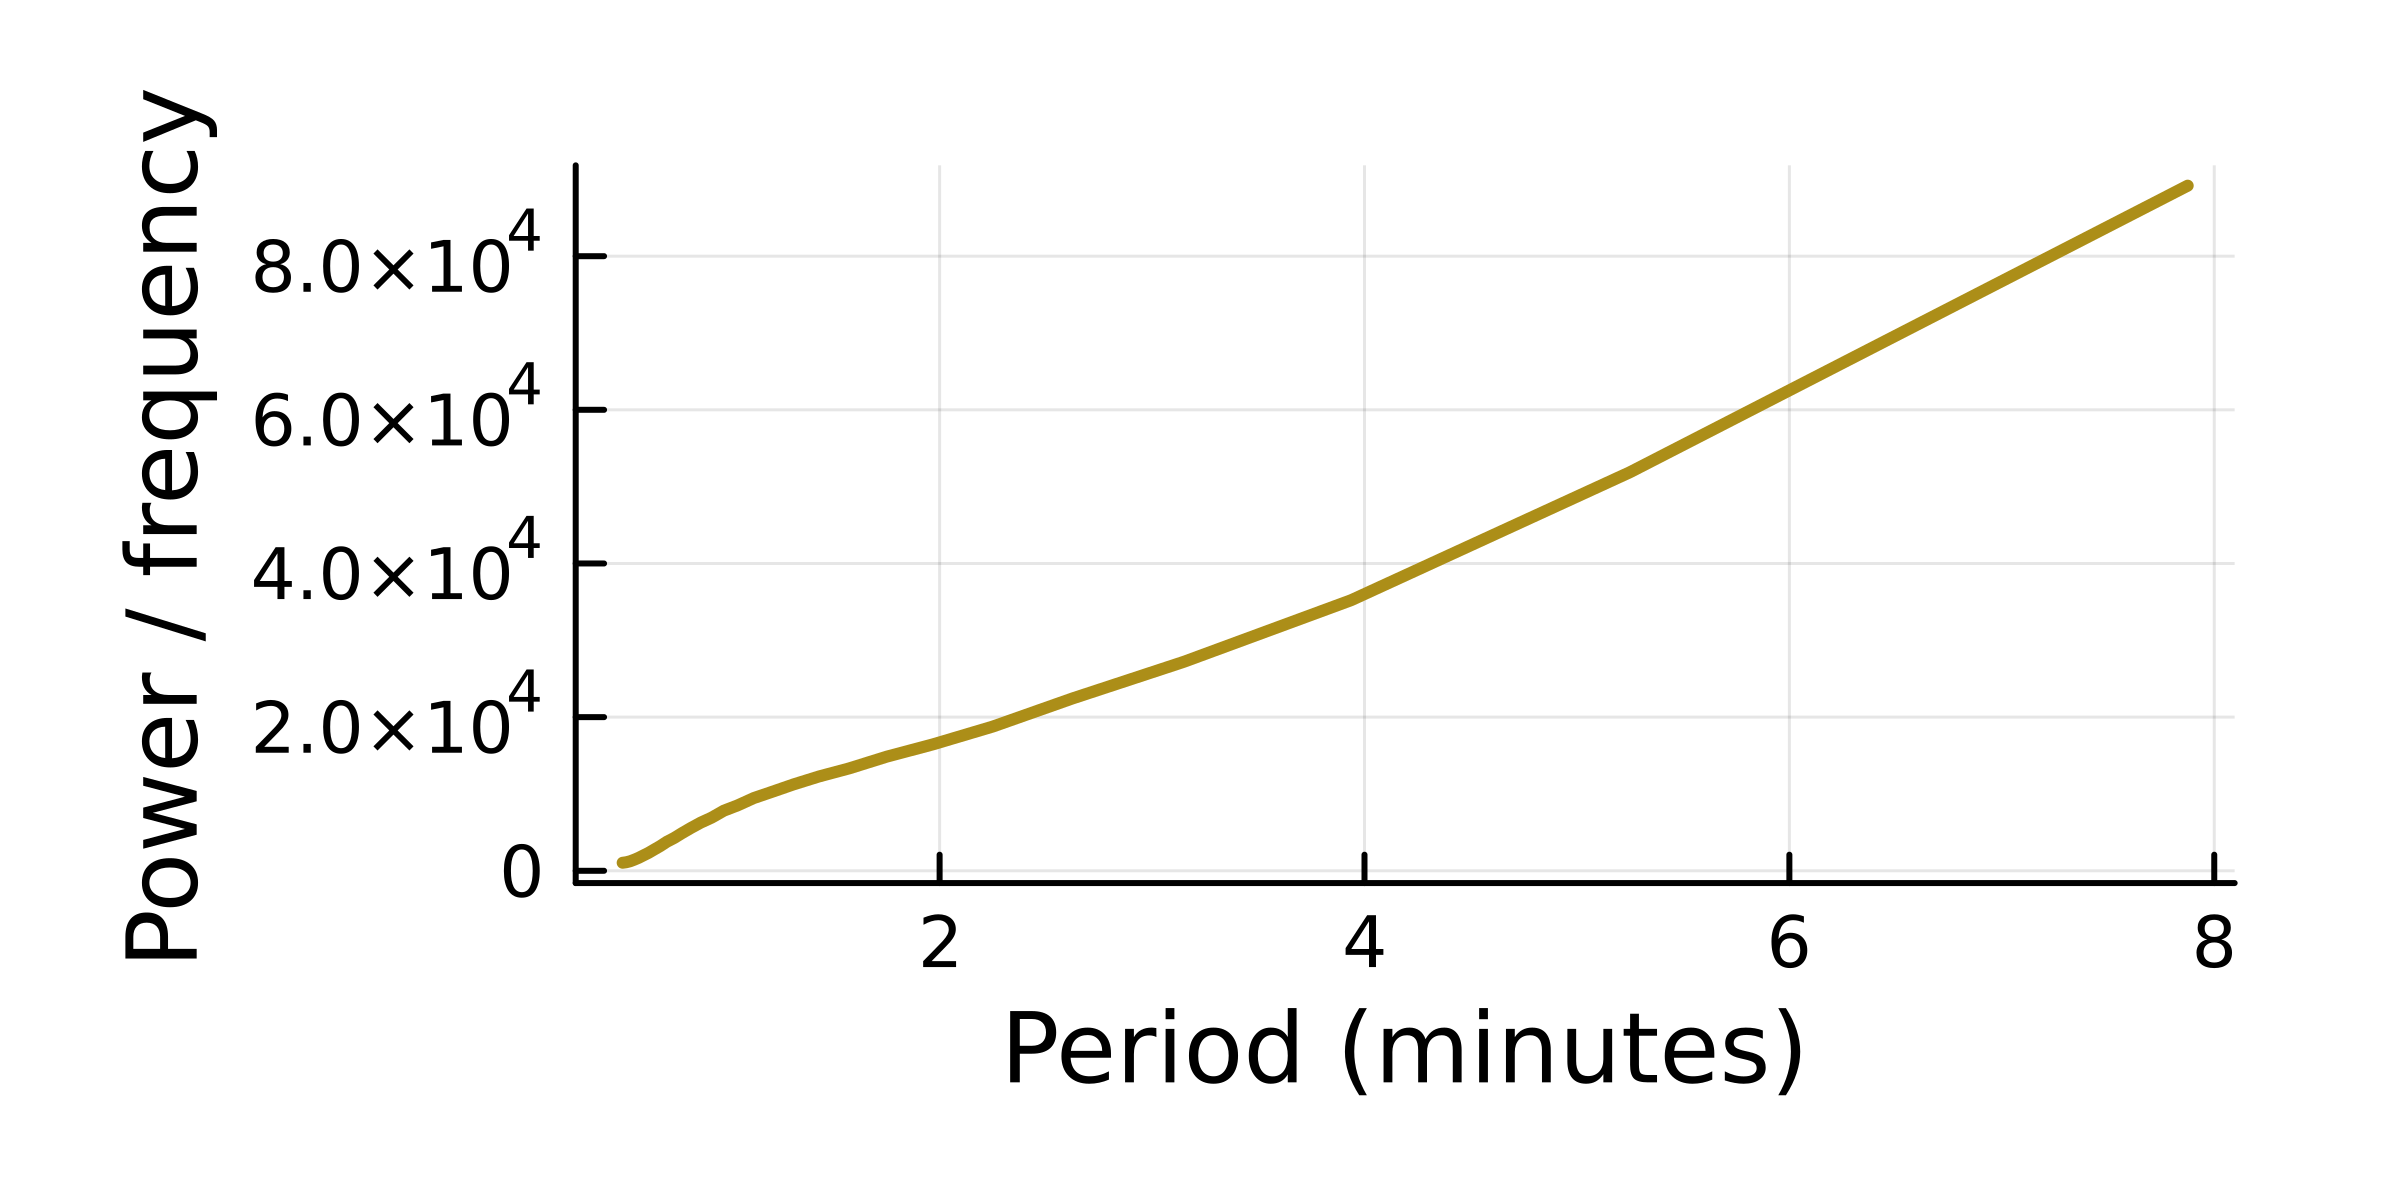

In [259]:
plot(1 ./ pdg_crop_max.freq[3:end] .* (15/60), mean(avg_pdg, dims=(1))[3:end], xflip = false, label=false, linewidth=2, alpha=1, margin=5Plots.mm, color=5,
    size=(400, 200), dpi=600, xlabel="Period (minutes)", ylabel="Power / frequency")
#savefig("biased_drift_avg_pdg_0p1.png")

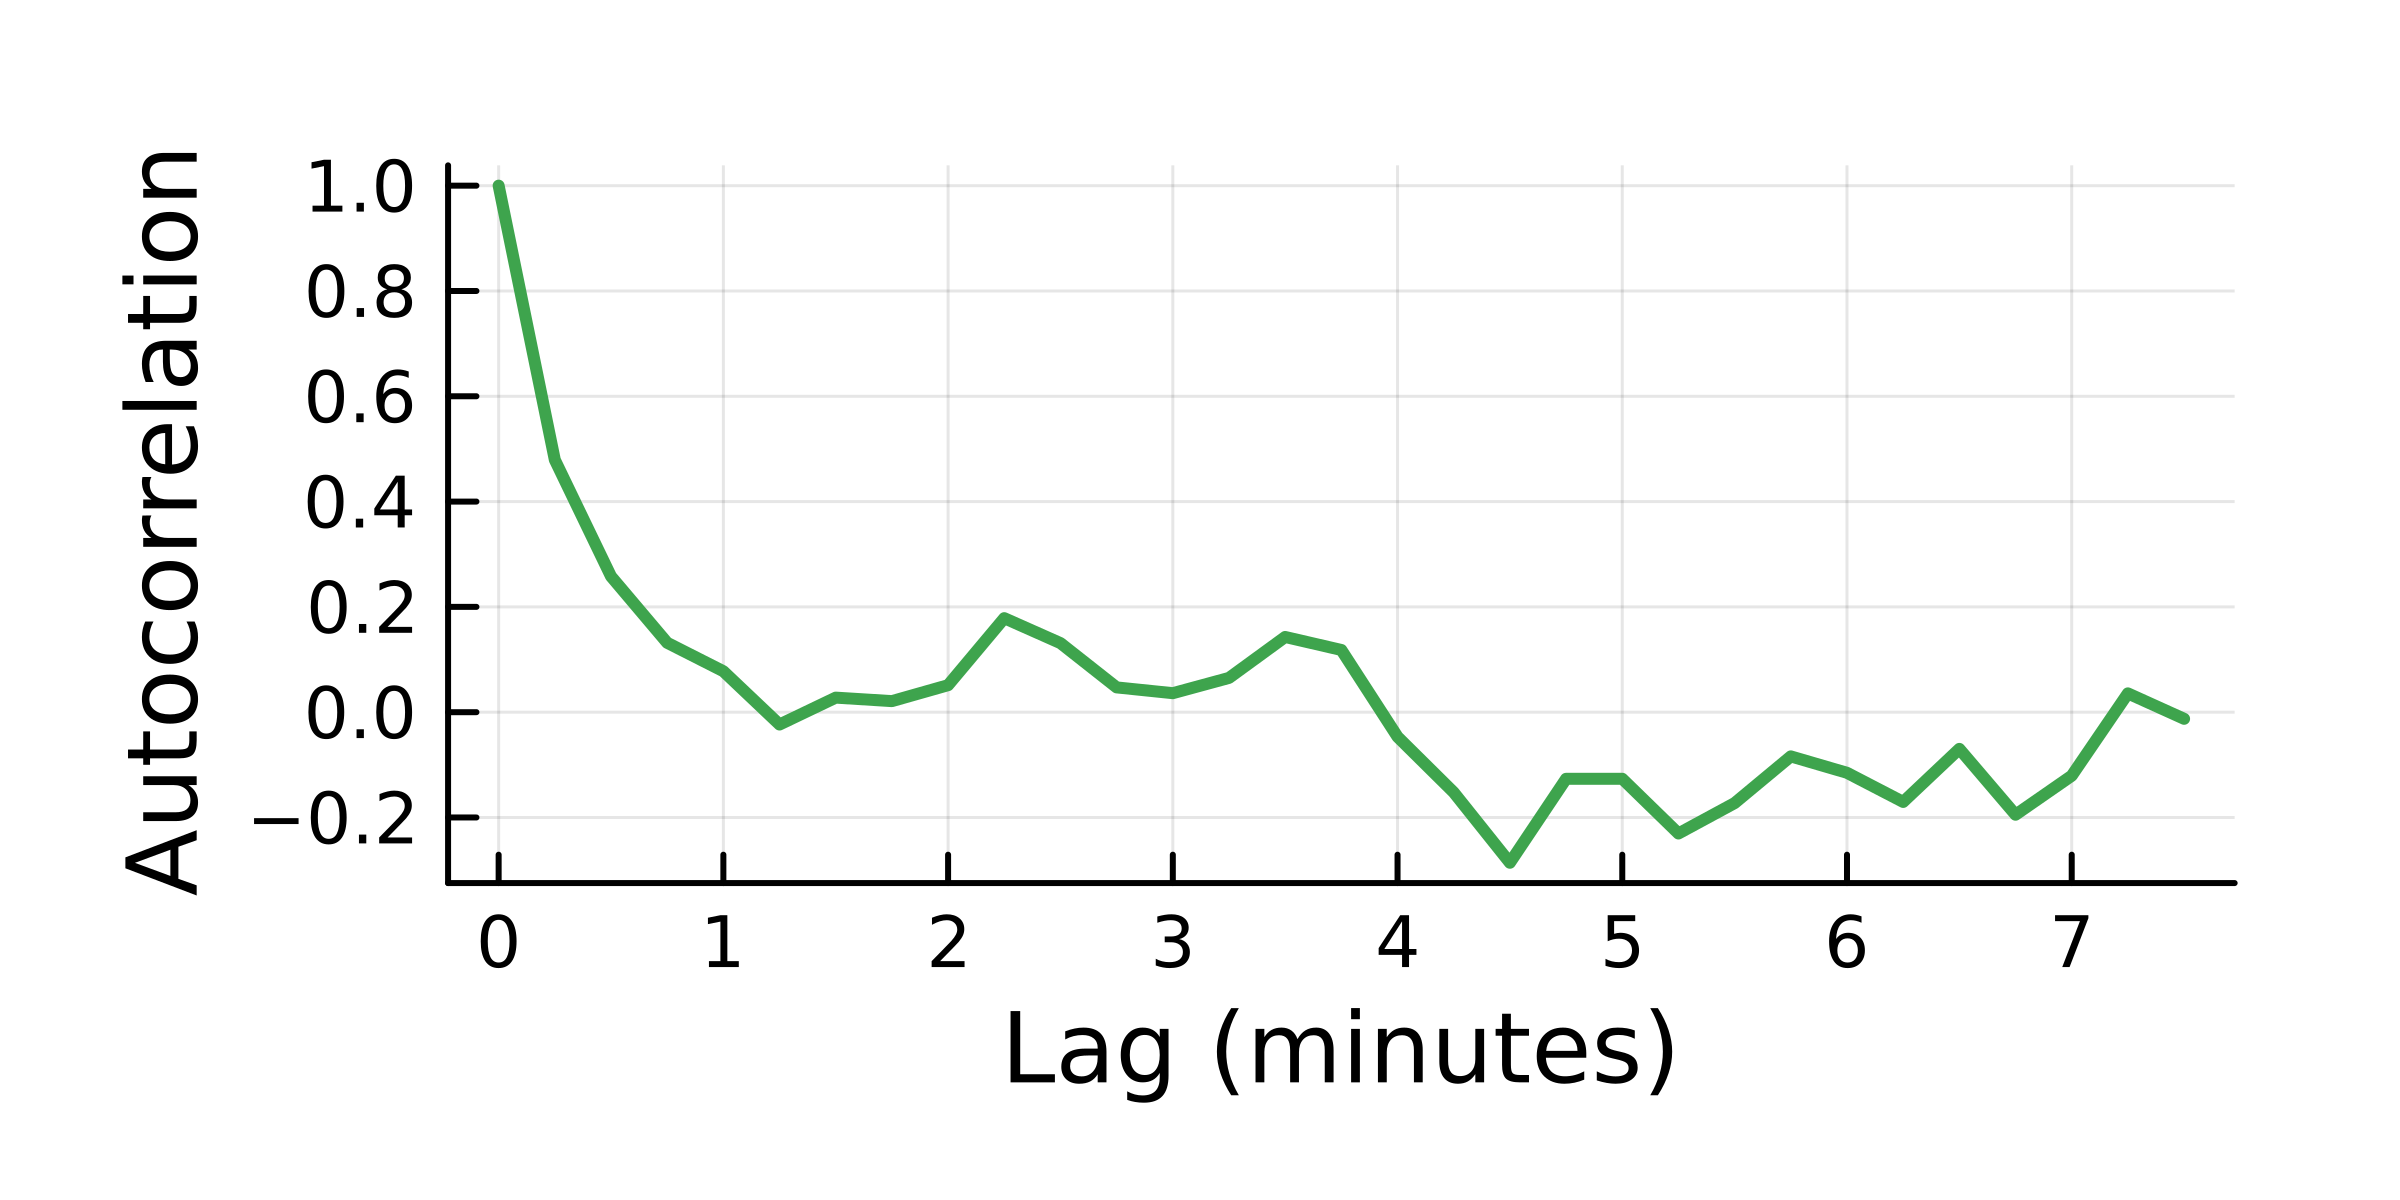

In [201]:
ac = crosscor(X, X, 0:30)
plot(range(0,30).*(15/60), ac, x_ticks=0:8, alpha=1, linewidth=2, color = 3, label=false, margin=5Plots.mm,
    size=(400, 200), dpi=600, xlabel="Lag (minutes)", ylabel="Autocorrelation")
#savefig("ac_biased_drift.png")

In [237]:
pdg_crop_max = DSP.Periodograms.periodogram(X)
plot(1 ./ pdg_crop_max.freq[3:end] .* (15/60), pdg_crop_max.power[3:end], xflip = false, label=false, linewidth=2, alpha=1, margin=5Plots.mm, color=5,
    size=(400, 200), dpi=600, xlabel="Period (minutes)", ylabel="Power / frequency")
savefig("pdg_biased_drift.png")

"/home/dinosaur/Lab/Polarity/proj/signal_and_noise/pdg_biased_drift.png"

In [208]:
length(pdg_crop_max.freq)

32